In [1]:
from tensorflow import set_random_seed
import numpy as np
np.random.seed(42)
set_random_seed(2)

import pandas as pd
import tensorflow as tf
import re

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, Embedding, GlobalMaxPooling2D, GlobalMaxPooling1D, Dropout, Reshape, Input, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.constraints import max_norm

from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import KFold

C:\Users\berna\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\berna\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip() if TREC else string.strip().lower()

In [3]:
def clean_str_sst(string):
    """
    Tokenization/string cleaning for the SST dataset
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)   
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip().lower()

In [4]:
np.random.seed(42)
set_random_seed(2)

#MR Dataset
train_neg = []
train_pos = []
with open('rt-polaritydata/rt-polarity.neg') as neg_r:
    for line in neg_r.readlines():
        train_neg.append(clean_str(line))
with open('rt-polaritydata/rt-polarity.pos') as pos_r:
    for line in pos_r.readlines():
        train_pos.append(clean_str(line))
train_data = np.concatenate((train_pos, train_neg))

pos_labels = np.ones(len(train_pos))
neg_labels = np.zeros(len(train_neg))
labels = np.concatenate((pos_labels, neg_labels))

shuffled_indices = list(range(len(train_data)))
np.random.shuffle(shuffled_indices)

train_data = train_data[shuffled_indices]
labels = labels[shuffled_indices]

n_classes = len(np.unique(labels))

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_size = 300
sentence_size = 59
X_train = tokenizer.texts_to_sequences(train_data)
X_train = pad_sequences(X_train, maxlen=sentence_size, padding='post')

In [6]:
reverse_word_index = {v: k for k,v in word_index.items()}
reverse_word_index[0] = '<PAD>'

In [7]:
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
embedding_weights = []
embedding_weights.append(list(np.zeros(embedding_size)))
for k, v in word_index.items():
    try:
        wv = w2v[k]
    except:
        wv = np.random.random(embedding_size)
    embedding_weights.append(list(wv))
embedding_weights = np.array(embedding_weights)

For all datasets we use: 
rectified linear units, 
filter windows (h) of 3, 4, 5 with 100 feature maps each,
dropout rate (p) of 0.5, 
l2 constraint (s) of 3,
mini-batch size of 50. 

These values were chosen
via a grid search on the SST-2 dev set.
We do not otherwise perform any datasetspecific tuning other than early stopping on dev
sets. For datasets without a standard dev set we
randomly select 10% of the training data as the
dev set. 
Training is done through stochastic gradient descent over shuffled mini-batches with the Adadelta update rule (Zeiler, 2012).

### Define model outside class

In [20]:
#Define model

static = True
rand = False
multichannel = True
conv_n_filters = 5
conv_filter_sizes = [3, 4, 5]
conv_window_size = (5, embedding_size)
pool_window_size = (4,4)
hidden_layer_size = 32
dropout_size = 0.5

inp = Input(shape=(sentence_size,))
if multichannel:
    emb1 = Embedding(vocab_size, embedding_size, weights=[embedding_weights], trainable=False)(inp)
    emb1 = Reshape((sentence_size, embedding_size, 1))(emb1)
    emb2 = Embedding(vocab_size, embedding_size, weights=[embedding_weights], trainable=True)(inp)
    emb2 = Reshape((sentence_size, embedding_size, 1))(emb2)
    x = Concatenate()([emb1, emb2])
else:
    if rand:
        emb = Embedding(vocab_size, embedding_size)(inp)
    elif static:
        emb = Embedding(vocab_size, embedding_size, weights=[embedding_weights], trainable=False)(inp)
    else:
        emb = Embedding(vocab_size, embedding_size, weights=[embedding_weights], trainable=True)(inp)
    x = Reshape((sentence_size, embedding_size, 1))(emb)

convolution_layer = []
for filter_size in conv_filter_sizes:
    conv_window_size = (filter_size, embedding_size)
    conv = Conv2D(conv_n_filters, conv_window_size, activation='relu', use_bias=True, padding='valid')(x)
    convolution_layer.append(GlobalMaxPooling2D()(conv))

x = Concatenate()(convolution_layer)
x = Dropout(dropout_size)(x)
x = Dense(1, activation='sigmoid', kernel_constraint=max_norm(3))(x)

model = Model(inputs=inp, outputs=x)

model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [21]:
### MULTICHANNEL
#model.save_weights('model.h5')
kf = KFold(10, random_state=42)
histories = []
i = 0
for train_index, test_index in kf.split(X_train):
    i += 1
    train_data, test_data = X_train[train_index], X_train[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    #model.load_weights('model.h5')
    print(f'Training split {i}')
    histories.append(model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=32, epochs=2))
    break

Training split 1


C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9595 samples, validate on 1067 samples
Epoch 1/2
9595/9595 [==============================] - 42s 4ms/step - loss: 0.6240 - acc: 0.6522 - val_loss: 0.5533 - val_acc: 0.7245
Epoch 2/2
9595/9595 [==============================] - 46s 5ms/step - loss: 0.5350 - acc: 0.7375 - val_loss: 0.5301 - val_acc: 0.7132


In [18]:
### STATIC
#model.save_weights('model.h5')
kf = KFold(10, random_state=42)
histories = []
i = 0
for train_index, test_index in kf.split(X_train):
    i += 1
    train_data, test_data = X_train[train_index], X_train[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    #model.load_weights('model.h5')
    print(f'Training split {i}')
    histories.append(model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=32, epochs=2))
    break

Training split 1
Train on 9595 samples, validate on 1067 samples
Epoch 1/2
9595/9595 [==============================] - 9s 942us/step - loss: 0.6262 - acc: 0.6486 - val_loss: 0.5556 - val_acc: 0.7366
Epoch 2/2
9595/9595 [==============================] - 10s 1ms/step - loss: 0.5480 - acc: 0.7294 - val_loss: 0.5302 - val_acc: 0.7310


In [16]:
### NON-STATIC
#model.save_weights('model.h5')
kf = KFold(10, random_state=42)
histories = []
i = 0
for train_index, test_index in kf.split(X_train):
    i += 1
    train_data, test_data = X_train[train_index], X_train[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    #model.load_weights('model.h5')
    print(f'Training split {i}')
    histories.append(model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=32, epochs=2))
    break

Training split 1


C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9595 samples, validate on 1067 samples
Epoch 1/2
9595/9595 [==============================] - 33s 3ms/step - loss: 0.6256 - acc: 0.6539 - val_loss: 0.5523 - val_acc: 0.7488
Epoch 2/2
9595/9595 [==============================] - 31s 3ms/step - loss: 0.5398 - acc: 0.7360 - val_loss: 0.5080 - val_acc: 0.7582


In [14]:
### RAND
#model.save_weights('model.h5')
kf = KFold(10, random_state=42)
histories = []
i = 0
for train_index, test_index in kf.split(X_train):
    i += 1
    train_data, test_data = X_train[train_index], X_train[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    #model.load_weights('model.h5')
    print(f'Training split {i}')
    histories.append(model.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=32, epochs=2))
    break

Training split 1


C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9595 samples, validate on 1067 samples
Epoch 1/2
9595/9595 [==============================] - 33s 3ms/step - loss: 0.6853 - acc: 0.5510 - val_loss: 0.6664 - val_acc: 0.6120
Epoch 2/2
9595/9595 [==============================] - 31s 3ms/step - loss: 0.6468 - acc: 0.6368 - val_loss: 0.6161 - val_acc: 0.6785


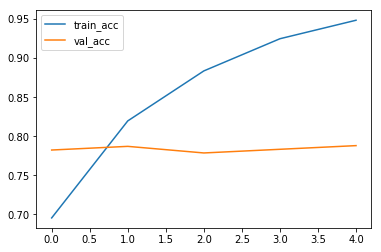

In [136]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

### Class CNN SENTENCE

In [113]:
class CNN_Sentence():
    def __init__(self, sentence_size, embedding_size, n_filters, filter_sizes, kernel_size, dropout_ratio, 
                 embedding_weights=None, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        inp = Input(shape=(sentence_size,))
        if embedding_weights is not None:
            emb = Embedding(vocab_size, embedding_size, weights=[embedding_weights])(inp)
        else:
            emb = Embedding(vocab_size, embedding_size)(inp)
        x = Reshape((sentence_size, embedding_size, 1))(emb)

        convolution_layer = []
        for filter_size in filter_sizes:
            conv_window_size = (filter_size, embedding_size)
            conv = Conv2D(n_filters, kernel_size, activation='relu', use_bias=True, padding='valid')(x)
            convolution_layer.append(GlobalMaxPooling2D()(conv))

        x = Concatenate()(convolution_layer)
        x = Dropout(dropout_ratio)(x)
        x = Dense(1, activation='sigmoid')(x)

        self._model = Model(inputs=inp, outputs=x)
        self._model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    def fit(self, x, y, batch_size=32, epochs=5):
        self._history = self._model.fit(x, y, batch_size, epochs)
        
    def predict(self, x):
        self._model.predict(x)
        
    def summary(self):
        print(self._model.summary())

In [115]:
model = CNN_Sentence(sentence_size=sentence_size, embedding_size=300, n_filters=5, filter_sizes=[3,4,5], 
                     kernel_size=[5,embedding_size], dropout_ratio=0.5, embedding_weights=embedding_weights)

In [117]:
model.fit(X_train, labels)

C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
10662/10662 [==============================] - 34s 3ms/step - loss: 0.5686 - acc: 0.7077
Epoch 2/5
10662/10662 [==============================] - 31s 3ms/step - loss: 0.3985 - acc: 0.8341
Epoch 3/5
10662/10662 [==============================] - 34s 3ms/step - loss: 0.2630 - acc: 0.9009
Epoch 4/5
10662/10662 [==============================] - 32s 3ms/step - loss: 0.1815 - acc: 0.9363
Epoch 5/5
10662/10662 [==============================] - 33s 3ms/step - loss: 0.1228 - acc: 0.9609


Using "same" padding results in the training being veeeeery slow. <br>
TF optimizers are not working properly and don't converge. However, Keras optimizers run into a denser tensor problem, which may impact performance.